In [407]:
import os
import math
import re
import functools
import itertools
from abc import ABC
from dataclasses import dataclass, field
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [57]:
from pyfinance.options import BSM as pyfinance_BSM

Add any general utility functions as static member functions to this class. They can be called as `Util.fn`.

In [2]:
class Util:
    def __init__(self):
        raise TypeError("Non-instantiable class")
        
    def __new__(self, *args, **kwargs):
        raise TypeError("Non-instantiable class")
        
    @staticmethod
    def make_regex_group_disjunction(coll):
        return "|".join(map(lambda x: f"({str(x)})", coll))

In [3]:
class OptionsData:
    data_dir = "data"
    default_filename = "isx2010C.xls"
    
    def __init__(self, filename=default_filename, clean=True):
        filepath = os.path.join(self.data_dir, filename)
        if not os.path.isfile(filepath):
            faulty_filepath = filepath
            filepath = os.path.join(self.data_dir, self.default_filename)
            print(f"Warning: could not find {faulty_filepath!r}; proceeding with {filepath!r}")
        self.__sheet_df_dict = pd.read_excel(filepath, sheet_name=None)
        if clean:
            for key, val in self.__sheet_df_dict.items():
                self.__sheet_df_dict[key] = self.__clean_df(val)
                
    def __get_item__(self, key):
        return self.__sheet_df_dict[key]
    
    def get_sheet_df_dict(self):
        return self.__sheet_df_dict
    
    def get_df(self, E=None, sheet_name=""):
        if not sheet_name:
            sheet_name = list(self.__sheet_df_dict.keys())[0]
            print(f"Warning: sheet name not specified; proceeding with {sheet_name!r}")
        df = self.__sheet_df_dict[sheet_name]
        common = ["T", "T_norm", "S", "r"]
        if not E:
            return df[[*common, *filter(lambda x: re.match(r"[0-9]+", x), df.columns)]]
        strikes = E if type(E) is list or type(E) is tuple else [E]
        cols = [*common, *map(lambda x: str(int(x)), strikes)]
        return df[cols]
    
    def __clean_df(self, df):
        # Discard rows where no options data is available.
        df = df.dropna(how="all")
        # Rename the columns according to the following convention:
        #  T = Time to Maturity
        #  S = Price of the Underlying
        #  r = Risk-Free Interest Rate
        df = df.rename(lambda x: self.__rename_df_cols(str(x), df), axis="columns")
        # Adjust the interest rate properly.
        df["r"] = df["r"] / 100
        # Add new column with annual-normalized T (252 = no. trading days in a year).
        df["T_norm"] = df["T"] / 252
        # Re-arrange the columns.
        common = ["S", "r", "T", "T_norm"]
        cols = [*common, *filter(lambda x: re.search("[0-9]+", x), df.columns.astype(str))]
        return df[cols]
    
    def __rename_df_cols(self, col_name, df):
        ncol = len(df.columns)
        # Time to maturity | (price of the underlying | risk-free rate).
        regex = r"(?P<T>[0-9]+(-[0-9]{2}){2} ([0-9]{2}:){2}[0-9]{2})|(?P<Sr>Unnamed: (?P<idx>[0-9]+))"
        match = re.match(regex, col_name)
        if not match:
            return col_name
        if match["T"]:
            return "T"
        elif match["Sr"]:
            col_idx = int(match["idx"])
            # Third last depicts the price of the underlying...
            if col_idx == ncol - 3:
                return "S"
            # ...and the second last the risk free rate.
            elif col_idx == ncol - 2:
                return "r"


In [4]:
data = OptionsData("isx2010C.xls")
data.get_df().tail()

,T,T_norm,S,r,340,345,350,355,360,365,370,375,380,385,390,395,400,405,410,415,420,425,430,435,440,445,450,455,460,465,470,475,480,485,490,495,500,505,510,515,520,525,530,535,540,545,550,555,560,565,570
81,5,0.019841,524.29,0.0006,185.50,180.50,175.50,170.50,165.50,160.50,155.50,150.50,145.50,140.50,135.50,130.50,125.50,120.50,115.50,110.50,105.50,100.50,95.50,90.50,85.40,80.40,75.40,70.40,65.4,60.40,55.40,50.45,45.45,40.45,35.45,30.50,25.55,20.00,15.70,11.0,6.8,3.00,1.00,0.30,0.10,0.07,0.05,0.05,0.05,0.05,0.05
82,4,0.015873,527.93,0.0006,188.55,183.55,178.55,173.55,168.55,163.55,158.55,153.55,148.55,143.55,138.55,133.55,128.55,123.55,118.55,113.55,108.55,103.55,98.55,93.55,88.55,83.55,78.55,73.55,68.7,63.55,58.55,53.55,48.60,43.65,38.65,33.65,28.60,23.65,18.65,14.0,9.0,4.50,1.60,0.40,0.15,0.07,0.05,0.05,0.05,0.15,0.15
83,3,0.011905,529.59,0.0006,190.10,185.10,180.10,175.10,170.10,165.10,160.10,155.10,150.10,145.10,140.10,135.10,130.10,125.10,120.10,115.10,110.10,105.10,100.10,95.10,90.10,85.10,80.10,75.10,70.1,65.10,60.10,55.10,50.30,45.10,40.10,35.10,30.80,26.00,20.00,15.7,10.1,5.65,1.95,0.40,0.05,0.05,0.02,0.05,0.05,0.15,0.05
84,2,0.007937,524.11,0.0005,184.10,179.10,174.10,169.10,164.10,159.10,154.10,149.10,144.10,139.10,134.10,129.10,124.10,119.10,114.10,109.10,104.10,99.10,94.10,89.10,84.10,79.10,74.10,69.10,63.1,59.10,54.10,49.10,45.50,41.25,34.58,27.80,24.00,19.40,14.10,9.1,4.1,0.05,0.05,0.04,0.05,0.05,0.01,0.05,0.05,0.05,0.05
85,1,0.003968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A class encapsulating the Black-Scholes-Merton model and related computations, such as Greeks. Can create instances from `pd.Series` objects (as returned by pd.DataFrame.iterrows) via the `BSM.make_from_series` factory method.

In [445]:
@dataclass(frozen=True)
class BSM:
    S: float
    E: float
    r: float
    T: float
    C_obs: float
    sigma: float = 1.0
    d1: float = field(init=False)
    d2: float = field(init=False)
    
    def __post_init__(self):
        S, E, r, T, C_obs, sigma = self.S, self.E, self.r, self.T, self.C_obs, self.sigma
        sigma = kys(kind='call', S0=S, K=E, T=T, r=r, sigma=0.3).implied_vol(C_obs)
        object.__setattr__(self, "sigma", sigma)
        eps = np.finfo(float).eps
        d1 = (math.log(S / E) + (r + 0.5 * self.sigma**2) * T) / (sigma * math.sqrt(T) + eps)
        
        object.__setattr__(self, "d1", d1)
        d2 = self.d1 - math.sqrt(self.sigma**2 * T)
        object.__setattr__(self, "d2", d2)
        
    @staticmethod    
    def make_from_dict(d, E):
        return BSM(d["S"], int(E), d["r"], d["T_norm"], d[E])
    
    @staticmethod
    def make_from_series(ser, E, sigma=1.0):
        ser = ser.filter(regex=Util.make_regex_group_disjunction(["S", int(E), "r", "T_norm"]), axis="index")
        assert ser.shape[0] == 4, f"Error: The series should have an index of form [S, E, r, T_norm], got {ser.index}."
        S, r, T, C_obs = ser.array
        return BSM(S, E, r, T, C_obs, sigma=sigma)
    
    @functools.cached_property
    def delta(self):
        return norm.cdf(self.d1)
    
    @functools.cached_property
    def gamma(self):
        return norm.pdf(self.d1) / (self.S * self.sigma * math.sqrt(self.T))
    
    @functools.cached_property
    def theta(self):
        S, E, r, T, sigma, d1, d2 = self.S, self.E, self.r, self.T, self.sigma, self.d1, self.d2
        return -0.5 * S * norm.pdf(d1) * sigma / math.sqrt(T) - r * E * math.exp(-r * T) * norm.cdf(d2)
    
    @functools.cached_property
    def vega(self):
        return self.S * math.sqrt(self.T) * norm.pdf(self.d1)
    
    def __implied_vol_objective(self, sigma0, S, E, r, T, C_obs):
        eps = np.finfo(float).eps
        d1 = (math.log(S / E) + (r + 0.5 * sigma0**2) * T) / (math.sqrt(sigma0**2 * T) + eps)
        d2 = d1 - math.sqrt(sigma0**2 * T)
        C = norm.cdf(d1) * S - E * math.exp(-r * T) * norm.cdf(d2)
        return 0.5 * (C - C_obs)**2

In [ ]:
minimize_scalar(self.__implied_vol_objective, args=(S, E, r, T, C_obs), bounds=(0,10000000))

In [446]:
test = data.get_df()
td = test.to_dict("index")
s, d = [], []
for t, row in td.items():
    #print(f"Day {t}")
    strikes = list(filter(lambda x: re.match(r"[0-9]+", x), row.keys()))
    BSMs = {}
    for E in strikes:
        BSMs[E] = BSM.make_from_dict(row, E)
    greeks = pd.DataFrame(index=strikes)
    greeks["delta"] = pd.Series([BSMs[E].delta for E in greeks.index], index=greeks.index)
    greeks["gamma"] = pd.Series([BSMs[E].gamma for E in greeks.index], index=greeks.index)
    greeks["vega"] = pd.Series([BSMs[E].vega for E in greeks.index], index=greeks.index)
    s.append(BSMs['480'].S)
    d.append(BSMs['480'].delta)
    #print(greeks)
    #print("-" * 50)

/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


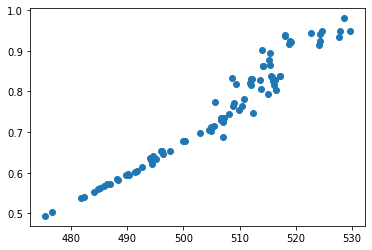

In [447]:
plt.scatter(s, d)

In [94]:
d

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 1.0,
 0.6056970700289867,
 0.5971883867518286,
 0.9999999999440673,
 0.603462849672082,
 0.6215490824585467,
 0.9999999999999899,
 0.6207524330459372,
 0.9999999999999982,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.614388985649172,
 0.6095872795403428,
 0.5823031656929265,
 0.9999999999537111,
 0.6004944652621274,
 0.5343126500756026,
 0.5257578961537376,
 0.5200975489179028,
 0.5904167421985635,
 0.6081005731144793,
 0.5337183823318651,
 0.5385053340586665,
 0.522011637630821,
 0.5220203284479177,
 0.6117000071421086,
 0.5927911598748706,
 0.5303734490604753,
 0.5438588980912495,
 0.5879908461086133,
 0.5641735707715904,
 0.5874322192303162,
 0.9999999999998542,
 0.9999999994339409,
 0.6053782275391917,
 0.5800649043737296,
 0.5642592433012528,
 0.6131761264365074,
 0.6234314324667077,
 1.0,
 0.9999999999999332,
 0.6175731172630765,
 0.5979023991266015,
 

In [7]:
E = 340
schedule = 2
df = data.get_df(E).dropna()

import time

t0 = time.time()
# t = 0:
rows_iterator = df.iterrows()
_, row = next(rows_iterator)
bsm_prev = BSM.make_from_series(row, E)
long_prev = bsm_prev.C_obs
delta_factor = bsm_prev.delta
short_prev = delta_factor * bsm_prev.S

# 0 < t < T:
mse = 0.0
for t, row in rows_iterator:
    bsm = BSM.make_from_series(row, E)
    long = bsm.C_obs
    dlong = long - long_prev
    short = delta_factor * bsm.S
    dshort = short - short_prev
    mse += (dlong - dshort)**2
    long_prev = long
    bsm_prev = bsm
    # Rehedge?
    if t % schedule == 0:
        delta_factor = bsm.delta
        short_prev = delta_factor * bsm.S
    else:
        short_prev = short

mse /= df.shape[0]

t1 = time.time()
print(f"Took {(t1 - t0)*1000:.2f} ms")

Took 163.38 ms


In [8]:
print(f"Single option delta hedging {mse=:.2f}")

Single option delta hedging mse=21.88


In [23]:
from pyfinance.options import BSM as kys


In [431]:
S0 = 529.59
E=480
T=0.011904761904761904
r=0.0006
sigma=0.3
Cobs = 50.3

In [432]:
implied_vol = kys(kind='call', S0=S0, K=E, T=T, r=r, sigma=0.3).implied_vol(Cobs)
implied_vol

0.5610319461548999

In [441]:
kys(kind='call', S0=S0, K=E, T=T, r=r, sigma=implied_vol).delta()

0.9491694788700725

In [434]:
a.value()

50.300000391994956

In [435]:
a.delta()

0.9491694788700725

In [436]:
bsm_a = BSM(S0, int(E), r, T, Cobs)

In [440]:
bsm_a.minim()

     fun: 2.762701264977487e-20
    nfev: 20
     nit: 16
 success: True
       x: -0.5610318812749725

In [438]:
bsm_a.delta

0.0

In [439]:
bsm_a.sigma

-0.010000000000000009

In [381]:
a.sigma

0.5610319461548999

In [371]:
td[83]

{'T': 3,
 'T_norm': 0.011904761904761904,
 'S': 529.59,
 'r': 0.0006,
 '340': 190.1,
 '345': 185.1,
 '350': 180.1,
 '355': 175.1,
 '360': 170.1,
 '365': 165.1,
 '370': 160.1,
 '375': 155.1,
 '380': 150.1,
 '385': 145.1,
 '390': 140.1,
 '395': 135.1,
 '400': 130.1,
 '405': 125.1,
 '410': 120.1,
 '415': 115.1,
 '420': 110.1,
 '425': 105.1,
 '430': 100.1,
 '435': 95.1,
 '440': 90.1,
 '445': 85.1,
 '450': 80.1,
 '455': 75.1,
 '460': 70.1,
 '465': 65.1,
 '470': 60.1,
 '475': 55.1,
 '480': 50.3,
 '485': 45.1,
 '490': 40.1,
 '495': 35.1,
 '500': 30.8,
 '505': 26.0,
 '510': 20.0,
 '515': 15.7,
 '520': 10.1,
 '525': 5.65,
 '530': 1.95,
 '535': 0.4,
 '540': 0.05,
 '545': 0.05,
 '550': 0.02,
 '555': 0.05,
 '560': 0.05,
 '565': 0.15,
 '570': 0.05}

In [17]:
row

{'T': 40,
 'T_norm': 0.15873015873015872,
 'S': 515.8,
 'r': 0.0004,
 '340': 176.05,
 '345': 171.05,
 '350': 166.05,
 '355': 161.05,
 '360': 156.05,
 '365': 151.05,
 '370': 146.05,
 '375': 141.0,
 '380': 136.0,
 '385': 131.1,
 '390': 126.05,
 '395': 121.0,
 '400': 116.0,
 '405': 111.05,
 '410': 106.2,
 '415': 101.2,
 '420': 96.2,
 '425': 91.3,
 '430': 86.4,
 '435': 81.55,
 '440': 76.65,
 '445': 71.8,
 '450': 67.0,
 '455': 62.25,
 '460': 57.9,
 '465': 52.8,
 '470': 48.2,
 '475': 43.7,
 '480': 39.35,
 '485': 35.1,
 '490': 30.95,
 '495': 27.0,
 '500': 23.25,
 '505': 19.7,
 '510': 16.2,
 '515': 13.6,
 '520': 11.0,
 '525': 8.9,
 '530': 6.5,
 '535': 5.05,
 '540': 3.7,
 '545': 2.65,
 '550': 1875.0,
 '555': 1.3,
 '560': 0.8,
 '565': 0.6,
 '570': 0.425}